In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Installing Dependencies

In [ ]:
# !pip3 install torch==1.12.0
# !pip3 install torchvision==0.13.0
# !pip3 install numpy==1.21.6


### Mounting Drive

In [ ]:
cd '/content/drive/MyDrive/Colab_Notebooks/U-Net/UNet-PyTorch'

/content/drive/MyDrive/Colab_Notebooks/U-Net/UNet-PyTorch


In [ ]:
!ls

 augmentation.py
 celldata.py
 checkpoints
 loss.py
 metric.py
 __pycache__
 runs
'U-Net: Convolutional Networks for Biomedical Image Segmentation.gdoc'
 unet.py
 UNET_pytorch_Notebook.ipynb


In [2]:
# web git clone
# models repository에 여러 하위 폴더가 있기 대문에 여기서는 repository 전체가 아닌 원하는 하위 폴더를 clone해야 함

!git init
!git remote add origin https://github.com/likespike/Models.git # clone하기 위한 저장소 연결
!git config core.sparsecheckout true    # sparse Checkout 기능 활성화
!echo UNet/UNet-PyTorch/* >> .git/info/sparse-checkout  # clone하기 위한 해당 폴더 Path 연결
!git pull origin main   # pull 명령어로 저장소에서 해당 폴더 파일 다운받기

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/
remote: Enumerating objects: 61, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 61 (delta 7), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (61/61), 20.77 MiB | 9.39 MiB/s, done.
From https://github.com/likespike/Models
 * branch            main       -> FETCH_HEAD
 * [new branch]      main       -> origin/main


In [5]:
# got clone 내용 -> content 폴더로 이동시키기
# custom packages, import위한 작업임

import os
import shutil

source_folder = '/content/UNet/UNet-PyTorch'
destination_folder = '/content/'

# 대상 폴더에 중복된 이름의 파일이 있는지 확인하고, 필요한 경우 파일을 복사하여 중복을 피합니다.
for item in os.listdir(source_folder):
    source_path = os.path.join(source_folder, item)
    destination_path = os.path.join(destination_folder, item)

    # 대상 폴더에 중복된 이름의 파일이 있는지 확인하고, 중복된 이름이라면 파일을 복사하여 다른 이름으로 저장합니다.
    if os.path.exists(destination_path):
        base_name, ext = os.path.splitext(item)
        count = 1
        while os.path.exists(os.path.join(destination_folder, f"{base_name}_{count}{ext}")):
            count += 1
        destination_path = os.path.join(destination_folder, f"{base_name}_{count}{ext}")

    # 폴더와 파일을 이동합니다.
    shutil.move(source_path, destination_path)

# 원본 폴더를 삭제합니다.
shutil.rmtree(source_folder)

# 원본 폴더의 상위 폴더까지 삭제하고 싶을 때
parent_folder = os.path.dirname(source_folder)
shutil.rmtree(parent_folder)

### Importing Libraries

In [6]:
import os
import argparse
import numpy as np
from skimage import io, transform
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import tifffile as tiff
from skimage.transform import resize
import torch
import torch.nn as nn
from torch import nn, optim, DoubleTensor
from torch import cuda
from torch.utils.data import DataLoader
from torch.utils.data.sampler import WeightedRandomSampler
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import transforms, datasets
#from unet import UNet
from celldata import CellDataset
from metric import iou, pix_acc
from loss import Weighted_Cross_Entropy_Loss
from augmentation import (
    DoubleCompose, DoubleToTensor,
    DoubleHorizontalFlip, DoubleVerticalFlip, DoubleElasticTransform,
    GaussianNoise
)



### Defining Variables

In [17]:

# pretrained_model_path='/content/drive/MyDrive/Colab_Notebooks/U-Net/UNet-PyTorch/checkpoints'
pretrained_model_path='/content/checkpoints'
# data_dir='/content/drive/MyDrive/Colab_Notebooks/data/VNC'
data_dir='/content/data/'
epochs=50
lr=0.0001   # 10의 -4승
batch_size=3
test_batch_size=3

## Defining UNet model
- U-Net은 모델 정의하는 부분과 inference하는 부분이 구분되어 있음


In [8]:
class UNet(torch.nn.Module):

    def __init__(self, n_classes, batch_norm=True):
        """
        """
        self.name = 'UNet'
        self.n_classes = n_classes  # class 개수 받아줌 (background, cell)
        self.filter_sizes = [64, 128, 256, 512, 1024]   # resolution이 줄어가면서 information loss가 많이 생김 -> filter size(channel) 늘려줌
        self.n_block = len(self.filter_sizes)
        self.batch_norm = batch_norm
        # self.num_layers = [2, 2, 2, 2, 2]

        super(UNet, self).__init__()
        self.contract_blocks = self.contract()
        self.expand_blocks = self.expand()
        self.segment = nn.Conv2d(
            self.filter_sizes[0],   # filter channel수 64개, input channel수 64개
            self.n_classes, # output channel 수 class 개수
            kernel_size=1   # 1x1
        )

    def forward(self, x):
        """Performs a forward pass through the network
        """
        xs = [] # feature map 담아 둘 list
        for block in self.contract_blocks:  # block들을 뽑아 냄
            new_x = block(x)    # block에 x를 넣어 new_x를 만듦
            xs.append(new_x)    # output으로 나온 feature를 xs에 append
            x = new_x   # 이 contract_block을 반복하면서 x는 계속 줄어듦

        for i, block in enumerate(self.expand_blocks):
            x = block['up'](x)  # x를 만들고
            k = self.n_block - i - 2
            x = self.concat(xs[k], x)   # concat을 수행 (몇 번째 expand_block인줄 알아야 xs에서 원하는 feature resolution을 찾을 수 있기 때문에 k, index 구성)
            x = block['conv'](x)    # 그다음 convolution 연산을 수행함

        y_pred = self.segment(x)    # segment convolution을 통과

        return y_pred

    def concat(self, x, y): # 두 feature을 concat을 할 때 resolution이 다를 경우, resolution을 맞춰 주는 함수
        """Crop and concatenate two feature maps
        """
        dw = (x.size()[2] - y.size()[2]) // 2
        dh = (x.size()[3] - y.size()[2]) // 2   # 여기서는 돌아가지만 다른거 할 때는 체크 y.size()[3]일 것 같음
        x = x[:, :, dw:x.size()[2] - dw, dh:x.size()[3] - dh]
        return torch.cat((x, y), 1)

    def contract(self):
        """Define contraction block in U-Net
        """
        blocks = []
        old = 1
        for i, size in enumerate(self.filter_sizes):
            mpool = nn.MaxPool2d(kernel_size=2)
            conv1 = nn.Conv2d(old, size, kernel_size=3)
            conv2 = nn.Conv2d(size, size, kernel_size=3)
            relu = nn.ReLU(True)
            convs = [mpool, conv1, relu, conv2, relu]   # 실제 연산 순서
            if self.batch_norm:
                b_norm = nn.BatchNorm2d(size)
                convs = [mpool, conv1, b_norm, relu, conv2, b_norm, relu]   # batch_normalization 사용 할 경우
            if i == 0:  # 첫 번째 blok에서는 max_pooling하지 않겠다, 그 다음부터 하겠다
                convs = convs[1:]
            block = nn.Sequential(*convs)   # 정의된 연산을 sequential로 하면 순서대로 지나겠다
            blocks.append(block)
            old = size
            self.add_module(f'contract{i+1}', block)    # add_module 함수로 contract number를 해당 block에 부여
        return blocks

    def expand(self):
        """Define expansion block in U-Net
        """
        blocks = []
        expand_filters = self.filter_sizes[self.n_block - 2::-1]    # filter_size를 거꾸로 불러옴, 1024가 아닌 512부터 시작하기에 -2부터
        old = self.filter_sizes[-1] # 입력값은 filter_size의 가자 마지막인 1024
        for i, size in enumerate(expand_filters):
            up = nn.ConvTranspose2d(old, size, kernel_size=2, stride=2)
            self.add_module(f'up{i+1}', up)
            conv1 = nn.Conv2d(old, size, kernel_size=3)
            conv2 = nn.Conv2d(size, size, kernel_size=3)
            relu = nn.ReLU(True)
            convs = [conv1, relu, conv2, relu]
            if self.batch_norm:
                b_norm = nn.BatchNorm2d(size)
                convs = [conv1, b_norm, relu, conv2, b_norm, relu]
            convs = nn.Sequential(*convs)
            self.add_module(f'deconv{i+1}', convs)
            blocks.append({'up': up, 'conv': convs})

            old = size

        return blocks


### Downloading Pretrained Model

In [10]:
if os.path.exists(pretrained_model_path) is False:
  print("Downloading pretrained model")
  os.makedirs(pretrained_model_path, exist_ok=True)
  !wget https://www.dropbox.com/s/mbwbv4k1kyjpz5f/UNet50.pt?dl=0 -O checkpoints/UNet50.pt
else:
  print('Already Downloaded')

--2023-09-06 04:13:46--  https://www.dropbox.com/s/mbwbv4k1kyjpz5f/UNet50.pt?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/mbwbv4k1kyjpz5f/UNet50.pt [following]
--2023-09-06 04:13:46--  https://www.dropbox.com/s/raw/mbwbv4k1kyjpz5f/UNet50.pt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbfbc336359566cca1d59f74e32.dl.dropboxusercontent.com/cd/0/inline/CDNhFW7x4BKMOu57FrJUvGHX5b5HyH3O_tTQRDlp0mJ-n71SQFVM7KDj0UPFM6xk06T0ulf5LYZzeOHDydwbMTI-BhV4_EkU-s06kAmL6JvOEK7itQMs8IDWpzUIgFr0MeSFXfM_Tvr01K57VdxggUcc/file# [following]
--2023-09-06 04:13:47--  https://ucbfbc336359566cca1d59f74e32.dl.dropboxusercontent.com/cd/0/inline/CDNhFW7x4BKMOu57FrJUvGHX5b5HyH3O_tTQRDlp0mJ-n71SQFVM7KDj0UPFM6xk06T0ulf5LYZzeOHDydwbMTI-BhV4_EkU-s06kAmL6

### Downloading VNC Dataset

In [18]:
if os.path.exists(data_dir) is False:
  print("Downloading Dataset")
  os.makedirs(data_dir, exist_ok=True)
  !wget https://github.com/hayashimasa/UNet-PyTorch/raw/main/data/test-volume.tif -O /content/drive/MyDrive/Colab_Notebooks/data/VNC/test-volume.tif
  !wget https://github.com/hayashimasa/UNet-PyTorch/raw/main/data/train-labels.tif -O /content/drive/MyDrive/Colab_Notebooks/data/VNC/train-labels.tif
  !wget https://github.com/hayashimasa/UNet-PyTorch/raw/main/data/train-volume.tif -O /content/drive/MyDrive/Colab_Notebooks/data/VNC/train-volume.tif
else:
  print('Dataset Already Downloaded')

Dataset Already Downloaded


### visualizing Dataset

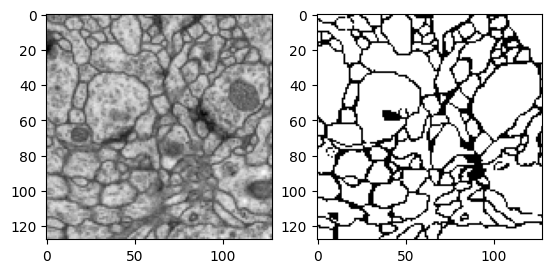

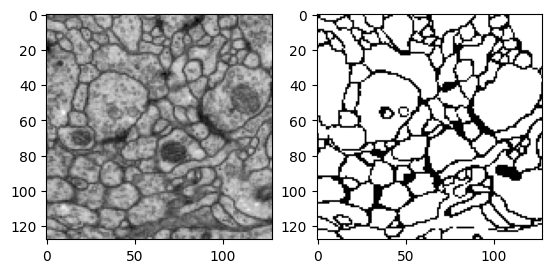

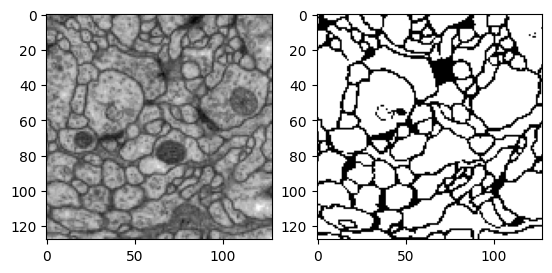

In [20]:
img_trn = tiff.imread(data_dir+f'/train-volume.tif')    # 16bit를 사용해서 이미지를 저장함 (의학용 이미지는 tif 많이 씀)
msk_trn = tiff.imread(data_dir+f'/train-labels.tif')

index=1
for img,msk in zip(img_trn, msk_trn):
    _img = resize(img, (128,128))
    _msk = resize(msk, (128,128)).round()
    fig,_ = plt.subplots(nrows=1, ncols=2)
    fig.axes[0].imshow(_img, cmap='gray')
    fig.axes[1].imshow(_msk, cmap='gray')
    plt.show()
    if(index==3):
      break
    index+=1


### Helper Functions for Loading Data and Training
- train 또는 test에서 사용되는 image transform

In [21]:
def get_train_loader(mean, std, out_size, batch_size, pct=.9):
    """Initialize Dataloader for training set

        mean (float): mean of pixel values
        std (float): standard deviation of pixel values
        out_size (int): dimension of segmentation map (out_size x out_size)
        batch_size (int): number of samples to load for each iteration
        pct (float): percentage of data to use for training (0 < pct <= 1)
    """
    image_mask_transform = DoubleCompose([
        DoubleToTensor(),   # doule로? 되어 있는 영상 포맷 -> tensor
        DoubleElasticTransform(alpha=250, sigma=10),    # deformations augmentation임
        DoubleHorizontalFlip(),
        DoubleVerticalFlip()
    ])
    image_transform = transforms.Compose([
        transforms.ColorJitter(brightness=0.4),
        transforms.Normalize(mean, std),
        GaussianNoise(),
        transforms.Pad(30, padding_mode='reflect')  # 영상 자체에 대한 padding
    ])
    mask_transform = transforms.CenterCrop(out_size)    # 위의 변형을 다 수행한 후에 CenterCrop함

    train_data = CellDataset(
        image_mask_transform=image_mask_transform,  # 위의 transform을 함수에 넣어줘서 train_data구성함
        image_transform=image_transform,
        mask_transform=mask_transform,
        pct=pct
    )
    train_loader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True
    )
    return train_loader


def get_test_loader(mean, std, out_size, batch_size):   # augmentation 부분은 필요없어 삭제
    """Initialize Dataloader for validation set

        mean (float): mean of pixel values
        std (float): standard deviation of pixel values
        out_size (int): dimension of segmentation map (out_size x out_size)
        batch_size (int): number of samples to load for each iteration
    """
    image_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
        transforms.Pad(30, padding_mode='reflect')  # padding된 상태의 영상을 tiling해가면서 inference하는 것이기 때문
    ])
    mask_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.CenterCrop(388)
    ])

    test_data = CellDataset(
        image_transform=image_transform,
        mask_transform=mask_transform,
        data_type='validate'
    )

    test_loader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=False
    )
    return test_loader


def train(model, device, data_loader, optimizer, criterion, epoch):
    """train model for one epoch    # 한 epoch에 대한 train함수 정의

    """
    model.train()
    loss = 0.
    for step, sample in enumerate(data_loader): # data_loader가 trainset전체를 들고와서 거기서 sample을 뽑음
        # forward pass
        X = sample['image'].to(device)
        y = sample['mask'].to(device)   # label
        w = sample['weight'].to(device) # Ensure Separation of Touching Objects 부분에 나왔던 mask임
        y = y.squeeze(1).long()  # remove channel dimension
        y_pred = model(X)

        # back propogation
        loss = criterion(y_pred, y, w)  # w를 사용한 loss function임
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # log
        log_interval = 1
        if step % log_interval == 0:
            print(
                'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, (step+1) * len(X), len(data_loader.dataset),
                    100. * (step+1) / len(data_loader), loss.item()
                )
            )
        # break

    return loss.item()


def validate(model, device, data_loader, criterion, n_classes):
    """Evaluate model performance with validation data

    """
    model.eval()    # model을 evaluation으로 바꿔줌
    test_loss = 0
    n = len(data_loader.dataset)
    class_iou = [0.] * n_classes
    pixel_acc = 0.
    with torch.no_grad():
        for sample in data_loader:
            X = sample['image'].to(device)
            y = sample['mask'].to(device)
            w = sample['weight'].to(device)
            y = y.squeeze(1).long()  # remove channel dimension
            y_pred = model(X)
            test_loss += criterion(y_pred, y, w).item()  # sum up batch loss
            pred = torch.argmax(y_pred, dim=1)  # class도 만들어야 해서 prediction된 y값에서 argmax로 어떤 class가 prediction됐는지 선택
            batch_size = X.shape[0]
            pred = pred.view(batch_size, -1)
            y = y.view(batch_size, -1)
            batch_iou = iou(pred, y, batch_size, n_classes) # iou 계산
            class_iou += batch_iou * (batch_size / n)
            pixel_acc += pix_acc(pred, y, batch_size) * (batch_size / n)    # pixel_accuracy 계산

    data_size = len(data_loader.dataset)
    test_loss /= data_size
    avg_iou = np.mean(class_iou)

    print(
        '\nValidation set: Average loss: {:.4f}, '.format(test_loss)
        + 'Average IOU score: {:.2f}, '.format(avg_iou)
        + 'Average pixel accuracy: {:.2f}\n'.format(pixel_acc)
    )
    return test_loss, avg_iou, pixel_acc


def initialize_model():
    """Initialize model checkpoint dictionary for storing training progress

    Args:
        args (object):
            epoch (int): total number of epochs to train model
            n_classes (int): number of segmentation classes
    """
    model_dict = {
        'total_epoch': epochs,
        'n_classes': 2,
        'model_state_dict': None,
        'optimizer_state_dict': None,
        'train_loss': list(),
        'test_loss': list(),
        'metrics': {
            'IOU': list(),
            'pix_acc': list(),
            'best': {
                'IOU': 0.,
                'pixel_acc': 0.,
                'epoch': 0
            }
        }
    }
    return model_dict


### Training

In [ ]:
def get_model(device):
    """Intialize or load model checkpoint and intialize model and optimizer

    """

    # Load model checkpoint
    model_dict = torch.load(pretrained_model_path+f'/UNet50.pt')
    # else:
    #     model_dict = initialize_model(args)
    n_classes = model_dict['n_classes'] # pre_trained된 model이 없으면 model dictionary를 initialize함
    model = UNet(n_classes).cuda() if device == 'cuda' else UNet(n_classes)
    optimizer = optim.Adam(model.parameters(),lr)

    model.load_state_dict(model_dict['model_state_dict'])   # device 설정
    optimizer.load_state_dict(model_dict['optimizer_state_dict'])   # optimizer 설정, parameters 넣어줌
    return model, optimizer, model_dict



    # args = parse_args()
    # if args.tensorboard:
writer = SummaryWriter()
# initialize model
device = (
    'cuda' if torch.cuda.is_available() else 'cpu'
)
model, optimizer, model_dict = get_model(device)
# initialize dataloader
mean = 0.495
std = 0.173
out_size = 388  # output dimension of segmentation map
train_loader = get_train_loader(mean, std, out_size, batch_size)
test_loader = get_test_loader(mean, std, out_size, test_batch_size)
# define loss function
criterion = Weighted_Cross_Entropy_Loss()
# train and evaluate model
start_epoch = 1

n_epoch = start_epoch + epochs - 1
model_path = pretrained_model_path
if not os.path.isdir(model_path):
    os.mkdir(model_path)
model_name =f'checkpoints/UNet{epochs}.pt'
for epoch in range(start_epoch, n_epoch + 1):
    train_loss = train(     #위에서 정의한 train함수로 train_loss 받아냄
        model, device, train_loader, optimizer, criterion, epoch
    )
    test_loss, test_iou, test_pix_acc = validate(
        model, device, test_loader, criterion, 2
    )
    # update tensorboard
    # if args.tensorboard:
    writer.add_scalar('Loss/train', train_loss, epoch)  # writer를 통해 원하는 값들을 출력할 수 있도록 함
    writer.add_scalar('Loss/test', test_loss, epoch)
    writer.add_scalar('IOU/test', test_iou, epoch)
    writer.add_scalar('Pixel_Accuracy/test', test_pix_acc, epoch)
    # record training progress
    model_dict['train_loss'].append(train_loss)
    model_dict['test_loss'].append(test_loss)
    model_dict['metrics']['IOU'].append(test_iou)
    model_dict['metrics']['pix_acc'].append(test_pix_acc)
    if epoch == 1 or test_iou > model_dict['metrics']['best']['IOU']:
        model_dict['model_state_dict'] = model.state_dict()
        model_dict['optimizer_state_dict'] = optimizer.state_dict()
        model_dict['metrics']['best']['IOU'] = test_iou
        model_dict['metrics']['best']['pix_acc'] = test_pix_acc
        model_dict['metrics']['best']['epoch'] = epoch
    # if args.save:
    torch.save(model_dict, model_name)  # model save
# if args.tensorboard:
writer.close()
print('Best IOU:', model_dict['metrics']['best']['IOU'])
print('Pixel accuracy:', model_dict['metrics']['best']['pix_acc'])


Train Epoch: 1 [3/27 (11%)]	Loss: 0.097797
Train Epoch: 1 [6/27 (22%)]	Loss: 0.079374
Train Epoch: 1 [9/27 (33%)]	Loss: 0.077177
Train Epoch: 1 [12/27 (44%)]	Loss: 0.073550
Train Epoch: 1 [15/27 (56%)]	Loss: 0.108778
Train Epoch: 1 [18/27 (67%)]	Loss: 0.048453
Train Epoch: 1 [21/27 (78%)]	Loss: 0.042346
Train Epoch: 1 [24/27 (89%)]	Loss: 0.109282
Train Epoch: 1 [27/27 (100%)]	Loss: 0.143235

Validation set: Average loss: 0.1080, Average IOU score: 0.67, Average pixel accuracy: 0.88

Train Epoch: 2 [3/27 (11%)]	Loss: 0.132333
Train Epoch: 2 [6/27 (22%)]	Loss: 0.067462
Train Epoch: 2 [9/27 (33%)]	Loss: 0.152125
Train Epoch: 2 [12/27 (44%)]	Loss: 0.043708
Train Epoch: 2 [15/27 (56%)]	Loss: 0.099390
Train Epoch: 2 [18/27 (67%)]	Loss: 0.125432
Train Epoch: 2 [21/27 (78%)]	Loss: 0.099867
Train Epoch: 2 [24/27 (89%)]	Loss: 0.098822
Train Epoch: 2 [27/27 (100%)]	Loss: 0.077264

Validation set: Average loss: 0.1028, Average IOU score: 0.73, Average pixel accuracy: 0.89

Train Epoch: 3 [3/27 (11

### Inference

/content/checkpoints/UNet50.pt


<Figure size 2000x2000 with 0 Axes>

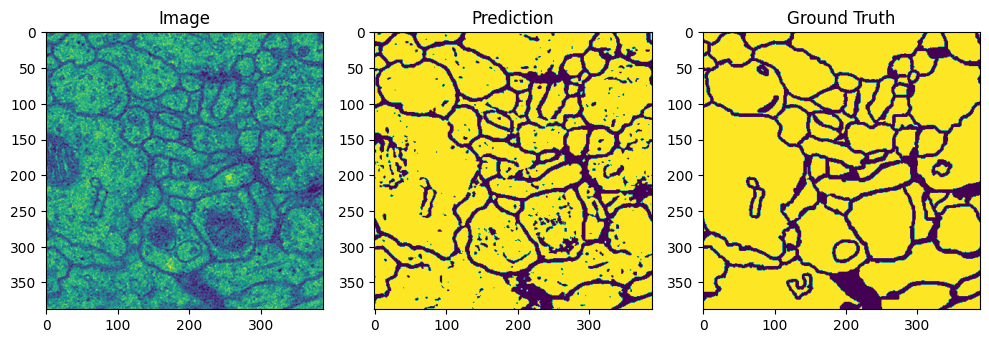

/content/checkpoints/UNet50.pt


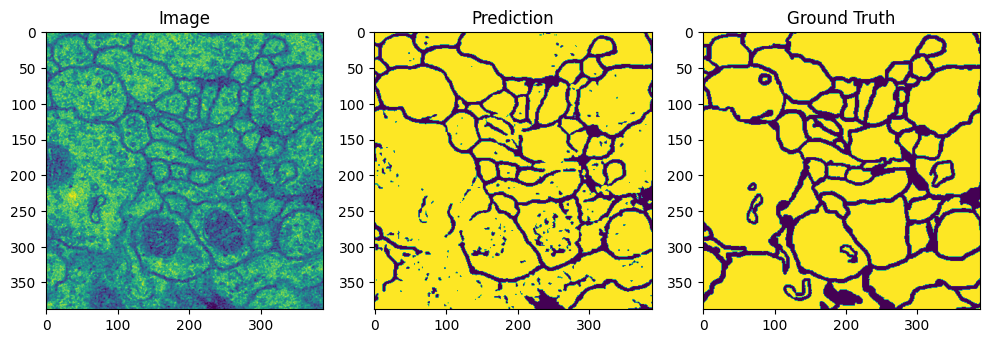

/content/checkpoints/UNet50.pt


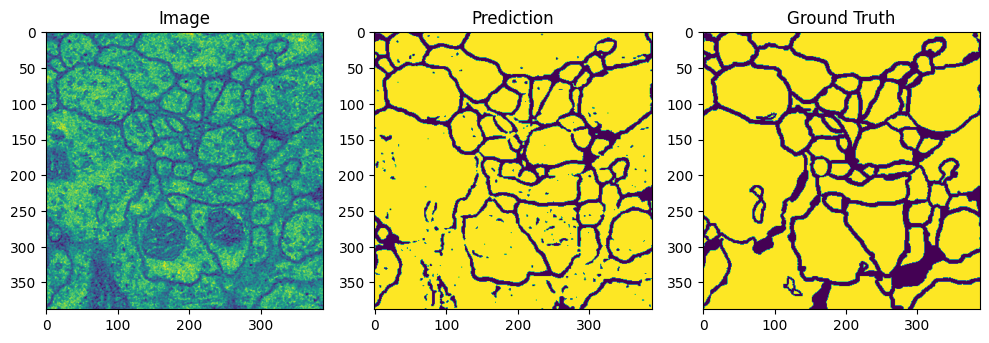

/content/checkpoints/UNet50.pt


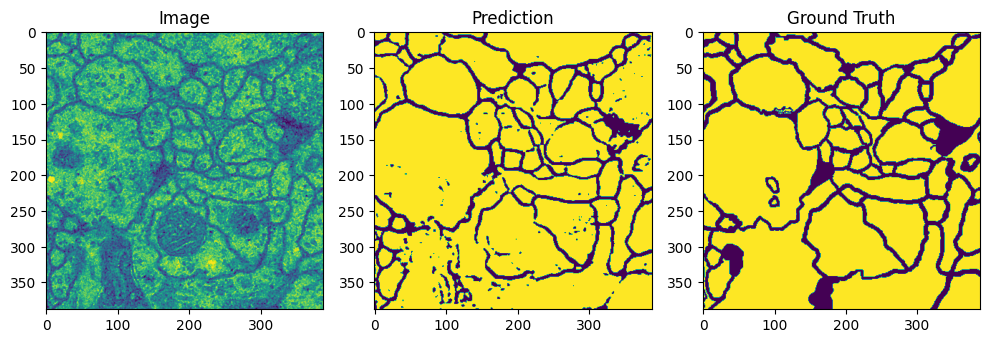

In [22]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.autolayout"] = True
plt.figure(figsize=(20,20))

def predict(image, model):
    """Make prediction on image"""
    mean = 0.495
    std = 0.173
    image_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
        transforms.Pad(30, padding_mode='reflect')
    ])
    im = image_transform(image)
    im = im.view(1, *im.shape)  # image 하나씩 inference하니까 batch_size가 1에 shape
    model.eval()
    y_pred = model(im)
    pred = torch.argmax(y_pred, dim=1)[0]
    return pred

def visualize(image, pred, label=None):
    """make visualization"""
    n_plot = 2 if label is None else 3
    fig = plt.figure()
    ax = fig.add_subplot(1, n_plot, 1)
    imgplot = plt.imshow(image)
    ax.set_title('Image')
    ax = fig.add_subplot(1, n_plot, 2)
    imgplot = plt.imshow(pred)
    ax.set_title('Prediction')
    if n_plot > 2:
        ax = fig.add_subplot(1, n_plot, 3)
        imgplot = plt.imshow(label)
        ax.set_title('Ground Truth')
    fig.tight_layout()

    plt.show()



for i in range(2,6):
    images = io.imread(data_dir+f'/train-volume.tif')
    labels = io.imread(data_dir+f'/train-labels.tif')
    image = images[-i]  # image를 뒤에서부터 가져 옴
    label = labels[-i]

    # load model
    print(pretrained_model_path+f'/UNet50.pt')
    checkpoint = torch.load(pretrained_model_path+f'/UNet50.pt', map_location=torch.device('cpu'))
    model = UNet(2)
    model.load_state_dict(checkpoint['model_state_dict'])
    # make inference
    pred = predict(image, model)

    # if args.visualize:
        # crop images for visualization
    dim = image.shape
    out_size = pred.shape[0]
    cut = (dim[0] - out_size) // 2
    image = image[cut:cut+out_size, cut:cut+out_size]
    label = label[cut:cut+out_size, cut:cut+out_size]
    # visualize result
    visualize(image, pred, label)


